In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 980

nband = 120

nv = 200

dv = 0.005

tsfc =300

ng =7

nref =2

p_refs = (/ 1 , 50 /) 

t_refs = (/ 250 , 250 /) 

ng_refs = (/ 4 , 3 /) 

data wgt
     &     /0.4 , 0.5 , 0.6 , 0.7,
     &     0.85 , 0.9 , 1/

option_wgt_flux =2

option_wgt_k =1

option_klin =0

data w_diffuse
     &     /1.6 , 1.6 , 1.6 , 1.6,
     &     1.6 , 1.6 , 1.6/

klin =0

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

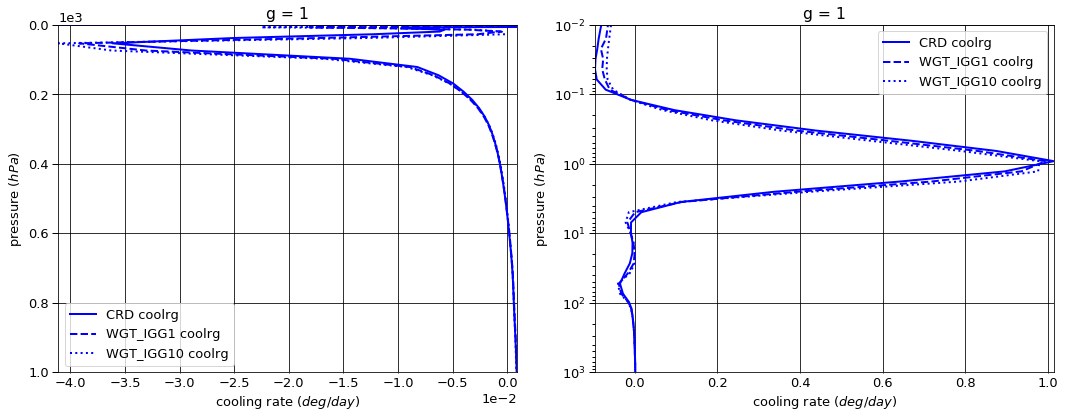

# Figure: cooling rate g-group 2

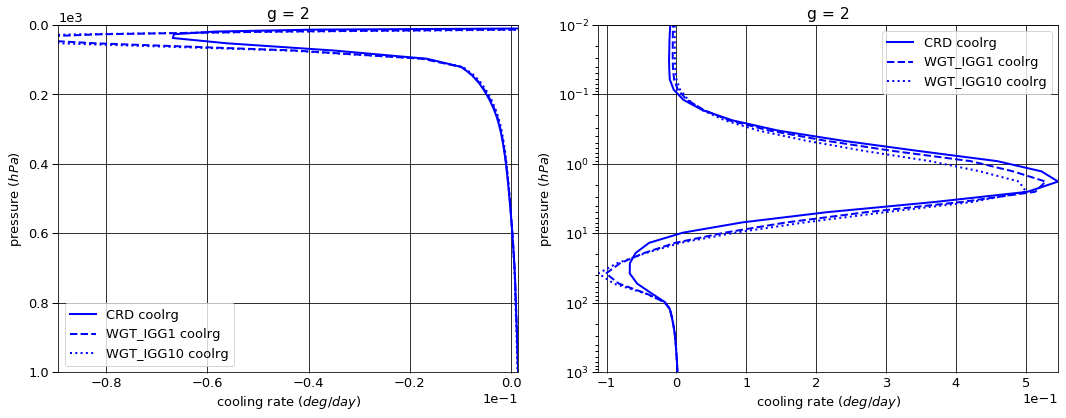

# Figure: cooling rate g-group 3

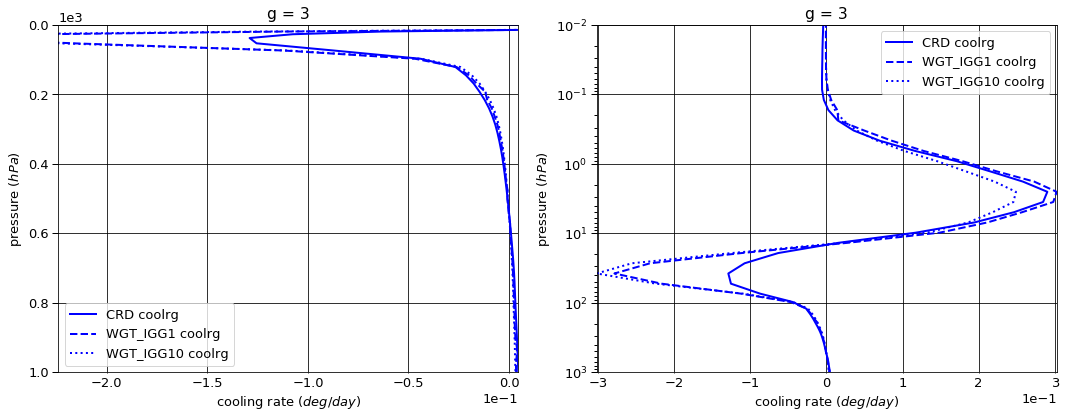

# Figure: cooling rate g-group 4

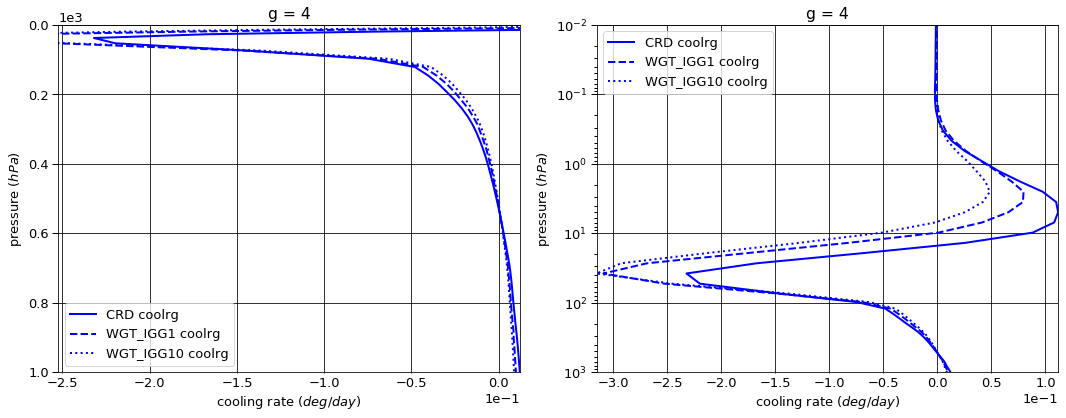

# Figure: cooling rate g-group 5

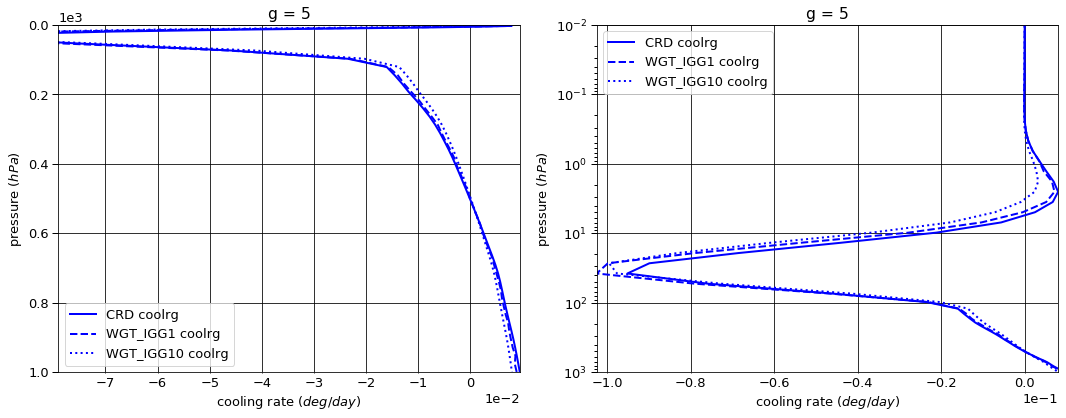

# Figure: cooling rate g-group 6

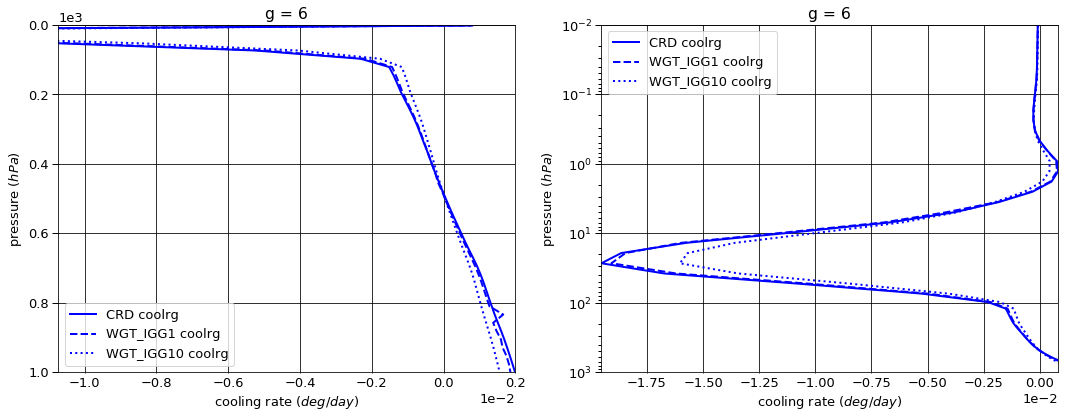

# Figure: cooling rate g-group 7

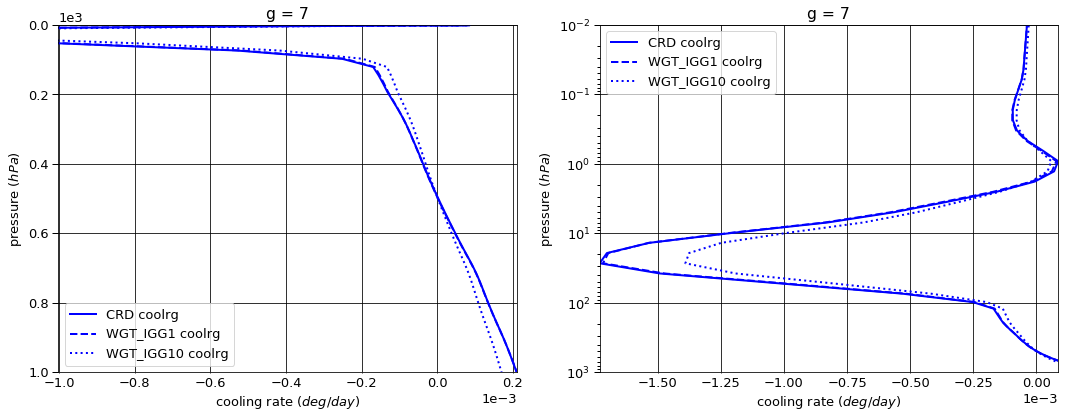

# Figure: cooling rate g-group total

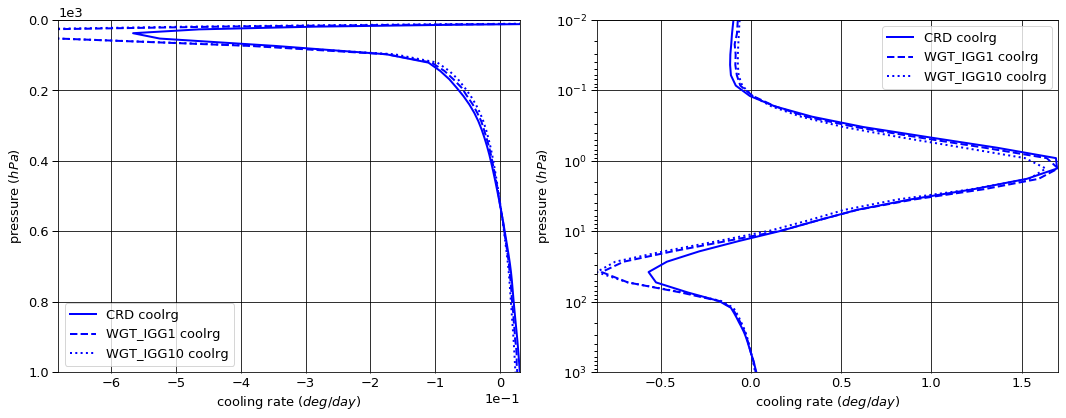

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.206910  0.000000 -0.206910
  1013.0   76    -0.455331  0.127362 -0.327969
2 0.0      1     -0.371789  0.000000 -0.371789
  1013.0   76    -0.939005  0.241788 -0.697217
3 0.0      1     -1.941367  0.000000 -1.941367
  1013.0   76    -3.604358  0.688641 -2.915717
4 0.0      1     -5.708165  0.000000 -5.708165
  1013.0   76    -9.114880  1.489914 -7.624966
5 0.0      1     -5.929020  0.000000 -5.929020
  1013.0   76    -7.472901  0.877792 -6.595109
6 0.0      1     -8.334314  0.000000 -8.334314
  1013.0   76    -8.570137  0.150415 -8.419722
7 0.0      1     -4.548941  0.000000 -4.548941
  1013.0   76    -4.572030  0.014909 -4.557121


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.211080  0.000000 -0.211080
  1013.0   76    -0.455331  0.126877 -0.328454
2 0.0      1     -0.321546  0.000000 -0.321546
  1013.0   76    -0.939005  0.232836 -0.706169
3 0.0      1     -1.298776  0.000000 -1.298776
  1013.0   76    -3.604358  0.709814 -2.894544
4 0.0      1     -5.381126  0.000000 -5.381126
  1013.0   76    -9.114880  1.378896 -7.735984
5 0.0      1     -5.916657  0.000000 -5.916657
  1013.0   76    -7.472901  0.842403 -6.630497
6 0.0      1     -8.341519  0.000000 -8.341519
  1013.0   76    -8.570137  0.143971 -8.426166
7 0.0      1     -4.549044  0.000000 -4.549044
  1013.0   76    -4.572030  0.014927 -4.557103


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.213908  0.000000 -0.213908
  1013.0   76    -0.455331  0.119306 -0.336025
2 0.0      1     -0.316095  0.000000 -0.316095
  1013.0   76    -0.939005  0.218667 -0.720338
3 0.0      1     -1.220106  0.000000 -1.220106
  1013.0   76    -3.604358  0.687288 -2.917070
4 0.0      1     -5.449621  0.000000 -5.449621
  1013.0   76    -9.114880  1.282210 -7.832670
5 0.0      1     -6.051895  0.000000 -6.051895
  1013.0   76    -7.472901  0.746297 -6.726604
6 0.0      1     -8.381599  0.000000 -8.381599
  1013.0   76    -8.570137  0.118065 -8.452073
7 0.0      1     -4.553464  0.000000 -4.553464
  1013.0   76    -4.572030  0.012047 -4.559982


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -4.170090e-03  0.000000 -0.004170
  1013.0   76     0.000000e+00 -0.000486 -0.000486
2 0.0      1      5.024224e-02  0.000000  0.050242
  1013.0   76     0.000000e+00 -0.008952 -0.008952
3 0.0      1      6.425914e-01  0.000000  0.642591
  1013.0   76    -4.440892e-16  0.021173  0.021173
4 0.0      1      3.270391e-01  0.000000  0.327039
  1013.0   76     1.776357e-15 -0.111018 -0.111018
5 0.0      1      1.236330e-02  0.000000  0.012363
  1013.0   76     0.000000e+00 -0.035388 -0.035388
6 0.0      1     -7.205200e-03  0.000000 -0.007205
  1013.0   76     0.000000e+00 -0.006444 -0.006444
7 0.0      1     -1.028000e-04  0.000000 -0.000103
  1013.0   76     0.000000e+00  0.000019  0.000019


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -6.997890e-03  0.000000 -0.006998
  1013.0   76     0.000000e+00 -0.008056 -0.008056
2 0.0      1      5.569365e-02  0.000000  0.055694
  1013.0   76     0.000000e+00 -0.023121 -0.023121
3 0.0      1      7.212611e-01  0.000000  0.721261
  1013.0   76    -4.440892e-16 -0.001353 -0.001353
4 0.0      1      2.585444e-01  0.000000  0.258544
  1013.0   76     1.776357e-15 -0.207704 -0.207704
5 0.0      1     -1.228749e-01  0.000000 -0.122875
  1013.0   76     0.000000e+00 -0.131495 -0.131494
6 0.0      1     -4.728490e-02  0.000000 -0.047285
  1013.0   76     0.000000e+00 -0.032350 -0.032350
7 0.0      1     -4.523000e-03  0.000000 -0.004523
  1013.0   76     0.000000e+00 -0.002861 -0.002861

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.031329
  1001.112500 75     0.000863
2 0.000312    1     -0.003435
  1001.112500 75     0.001411
3 0.000312    1     -0.001488
  1001.112500 75     0.004588
4 0.000312    1     -0.000427
  1001.112500 75     0.012144
5 0.000312    1     -0.000014
  1001.112500 75     0.009491
6 0.000312    1     -0.000028
  1001.112500 75     0.001993
7 0.000312    1     -0.000012
  1001.112500 75     0.000210


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.024951
  1001.112500 75     0.000888
2 0.000312    1     -0.002136
  1001.112500 75     0.001406
3 0.000312    1     -0.000386
  1001.112500 75     0.003531
4 0.000312    1     -0.000211
  1001.112500 75     0.009931
5 0.000312    1     -0.000013
  1001.112500 75     0.008900
6 0.000312    1     -0.000027
  1001.112500 75     0.001863
7 0.000312    1     -0.000012
  1001.112500 75     0.000210


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.021750
  1001.112500 75     0.000833
2 0.000312    1     -0.001254
  1001.112500 75     0.001274
3 0.000312    1     -0.000319
  1001.112500 75     0.003179
4 0.000312    1     -0.000235
  1001.112500 75     0.008817
5 0.000312    1     -0.000013
  1001.112500 75     0.007978
6 0.000312    1     -0.000023
  1001.112500 75     0.001564
7 0.000312    1     -0.000009
  1001.112500 75     0.000170


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      6.377473e-03
  1001.112500 75     2.505284e-05
2 0.000312    1      1.298571e-03
  1001.112500 75    -4.809300e-06
3 0.000312    1      1.102258e-03
  1001.112500 75    -1.057486e-03
4 0.000312    1      2.155868e-04
  1001.112500 75    -2.213438e-03
5 0.000312    1      9.214340e-07
  1001.112500 75    -5.911845e-04
6 0.000312    1      8.839920e-07
  1001.112500 75    -1.295450e-04
7 0.000312    1      6.787000e-08
  1001.112500 75     3.970700e-07


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      9.578629e-03
  1001.112500 75    -3.056637e-05
2 0.000312    1      2.180951e-03
  1001.112500 75    -1.372111e-04
3 0.000312    1      1.169130e-03
  1001.112500 75    -1.409388e-03
4 0.000312    1      1.919965e-04
  1001.112500 75    -3.327166e-03
5 0.000312    1      6.583830e-07
  1001.112500 75    -1.513302e-03
6 0.000312    1      4.734310e-06
  1001.112500 75    -4.291630e-04
7 0.000312    1      2.271811e-06
  1001.112500 75    -4.004308e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-27.040507,0.000000,-27.040507
1013.0,76,-34.728642,3.590821,-31.137821



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.019749,0.000000,-26.019749
1013.0,76,-34.728642,3.449725,-31.278917



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-26.186689,0.000000,-26.186689
1013.0,76,-34.728642,3.183881,-31.544761



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.020758,0.000000,1.020758
1013.0,76,0.000000,-0.141096,-0.141096



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.853818,0.00000,0.853818
1013.0,76,0.000000,-0.40694,-0.406940


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.036731
1001.112500,75,0.030701



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.027736
1001.112500,75,0.026730



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.023603
1001.112500,75,0.023814



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.008996
1001.112500,75,-0.003971



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.013128
1001.112500,75,-0.006887


In [20]:
table_dgdgs.display_dgdgs(crd)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.013083,0.013101
2,0.026792,0.027120
3,0.102833,0.104146
4,0.259042,0.263859
5,0.212917,0.216035
6,0.245292,0.247839
7,0.140042,0.127900


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,2.310613e-18
2,2.305341e-19
3,2.300081e-20
4,2.294833e-21
5,1.127464e-20
6,1.127564e-21
7,1.127665e-22


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,2.310613e-18,NaN,0.013083,0.013101,0.013083,0.013101,1.0
2,2.305341e-19,0.099772,0.026792,0.027120,0.039875,0.040221,1.0
3,2.300081e-20,0.099772,0.102833,0.104146,0.142708,0.144366,1.0
4,2.294833e-21,0.099772,0.259042,0.263859,0.401750,0.408226,1.0
5,1.127464e-20,4.913053,0.212917,0.216035,0.614667,0.624261,50.0
6,1.127564e-21,0.100009,0.245292,0.247839,0.859958,0.872100,50.0
7,1.127665e-22,0.100009,0.140042,0.127900,1.000000,1.000000,50.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     8.129405e-18  4.530236e-18   1.794477  9.507650e-06
      2 0.000312     5.168431e-19  2.809837e-19   1.839406  6.353082e-07
      3 0.000312     3.156821e-20  1.766637e-20   1.786910  4.141943e-08
      4 0.000312     2.494670e-21  1.157876e-21   2.154523  3.334311e-09
      5 0.000312     8.879803e-23  8.717360e-23   1.018634  1.410314e-10
      6 0.000312     1.075124e-22  8.450203e-23   1.272306  1.675593e-10
      7 0.000312     7.806923e-23  2.374959e-23   3.287182  1.243328e-10
2     1 0.000750     8.125867e-18  4.534078e-18   1.792176  4.337477e-06
      2 0.000750     5.182715e-19  2.818831e-19   1.838604  2.906358e-07
      3 0.000750     3.170847e-20  1.774548e-20   1.786847  1.897723e-08
      4 0.000750     2.504663e-21  1.164402e-21   2.151030  1.527421e-09
      5 0.000750     8.963636e-23  8.800341e-23   1.018556  6.493832e-11
      6 0.000750     1.081088e-22  8.499686e-23   1.271915  7.685654e-11
      7 0.000750     7.826630e-23  2.383065e-23   3.284271  5.685648e-11
3     1 0.001052     8.118916e-18  4.541766e-18   1.787612  7.510823e-06
      2 0.001052     5.211247e-19  2.836403e-19   1.837273  5.060125e-07
      3 0.001052     3.198352e-20  1.788785e-20   1.788002  3.313024e-08
      4 0.001052     2.522965e-21  1.174838e-21   2.147500  2.664134e-09
      5 0.001052     9.089761e-23  8.924815e-23   1.018482  1.139963e-10
      6 0.001052     1.092775e-22  8.595633e-23   1.271315  1.344882e-10
      7 0.001052     7.866506e-23  2.398835e-23   3.279302  9.892455e-11
4     1 0.001476     8.111772e-18  4.549509e-18   1.783000  1.255270e-05
      2 0.001476     5.240343e-19  2.854408e-19   1.835878  8.503842e-07
      3 0.001476     3.226729e-20  1.803653e-20   1.788997  5.583605e-08
      4 0.001476     2.542211e-21  1.186044e-21   2.143437  4.486555e-09
      5 0.001476     9.228634e-23  9.061977e-23   1.018391  1.933753e-10
      6 0.001476     1.104940e-22  8.695420e-23   1.270715  2.272103e-10
      7 0.001476     7.907747e-23  2.415068e-23   3.274337  1.661477e-10
5     1 0.002070     8.104508e-18  4.557201e-18   1.778396  2.045096e-05
      2 0.002070     5.269653e-19  2.872665e-19   1.834412  1.393196e-06
      3 0.002070     3.255703e-20  1.819125e-20   1.789708  9.174924e-08
      4 0.002070     2.562350e-21  1.198137e-21   2.138612  7.368099e-09
      5 0.002070     9.382739e-23  9.214334e-23   1.018276  3.202233e-10
      6 0.002070     1.117477e-22  8.798271e-23   1.270110  3.742805e-10
      7 0.002070     7.949872e-23  2.431614e-23   3.269380  2.720534e-10
6     1 0.002904     8.097098e-18  4.564847e-18   1.773794  3.270186e-05
      2 0.002904     5.299217e-19  2.891250e-19   1.832846  2.240338e-06
      3 0.002904     3.285394e-20  1.835419e-20   1.789996  1.480018e-07
      4 0.002904     2.583631e-21  1.211448e-21   2.132679  1.188201e-08
      5 0.002904     9.557478e-23  9.387296e-23   1.018129  5.214549e-10
      6 0.002904     1.130457e-22  8.904847e-23   1.269485  6.052996e-10
      7 0.002904     7.992948e-23  2.448557e-23   3.264351  4.372622e-10
7     1 0.004074     8.089502e-18  4.572449e-18   1.769184  5.153832e-05
      2 0.004074     5.329105e-19  2.910273e-19   1.831136  3.550966e-06
      3 0.004074     3.315981e-20  1.852841e-20   1.789674  2.353749e-07
      4 0.004074     2.606407e-21  1.226445e-21   2.125172  1.889755e-08
      5 0.004074     9.760468e-23  9.588485e-23   1.017936  8.390800e-10
      6 0.004074     1.143975e-22  9.016098e-23   1.268814  9.651588e-10
      7 0.004074     8.037074e-23  2.466016e-23   3.259133  6.927557e-10
8     1 0.005714     8.081659e-18  4.580021e-18   1.764546  8.028444e-05
      2 0.005714     5.359433e-19  2.929898e-19   1.829221  5.563788e-06
      3 0.005714     3.347734e-20  1.871828e-20   1.788484  3.701489e-07
      4 0.005714     2.631186e-21  1.243786e-21   2.115466  2.973365e-08
      5 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
